In [1]:
import os
import pandas as pd
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
import torch

## Drawing Utility

Takes in a undirected graph, and a color map, and draw the graph out in a circular format. 

In [2]:
from torch_geometric.utils import to_networkx

def draw_entry(entry):
    g = to_networkx(entry)
    label = entry["y"]
    
    # Create color map from selected nodes, green for selected, grey for unselected.
    color_map = ["grey"] * len(g.nodes)

    for i in np.flatnonzero(label):
        color_map[i] = "green"
        
    node_lables = nx.get_node_attributes(g, "weight")
    
    if node_lables:
        node_lables = {k: "{0}: {1}".format(k, v) for (k, v) in node_lables.items()}
    else:
        node_lables = {k: k for k in g.nodes}
    
    plt.figure()
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, pos, node_lables)
    plt.show()  
    # plt.savefig("graph.png", dpi=1000)


In [3]:
dataset_name = "large_binomial_80"
root_dir = "data/" + dataset_name
label_filename = "label.csv"

# Read CSV File
label_arr = []
with open(os.path.join(root_dir, label_filename), 'r') as label_file:
    label_reader = csv.reader(label_file, delimiter = ",")
    for row in label_reader:
        label_arr.append([row[0]] + sorted(row[1:]))
label_frame = pd.DataFrame(data=label_arr)
label_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,binomial0.txt,23,24,25,26,33,39,4,45,50,...,66,71,75,78,8,None,None,None,None,None
1,binomial1.txt,1,10,16,24,32,48,50,51,56,...,62,68,69,70,None,None,None,None,None,None
2,binomial2.txt,10,12,18,25,41,42,53,54,55,...,65,67,72,8,9,None,None,None,None,None
3,binomial3.txt,10,15,17,21,23,24,30,31,40,...,64,71,73,74,None,None,None,None,None,None
4,binomial4.txt,11,12,13,17,2,20,28,3,37,...,52,55,59,64,7,75,77,None,None,None


In [4]:
import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.utils import from_networkx

class MaxIndSetDataset(InMemoryDataset):
    """Graphs labelled with its Maximum Independent Set"""
    
    def __init__(self, csv_file = None, root_dir = None, tar_dir = None):
        if csv_file and root_dir:
            # Read CSV File
            label_arr = []
            with open(os.path.join(root_dir, label_filename), 'r') as label_file:
                label_reader = csv.reader(label_file, delimiter = ",")
                for row in label_reader:
                    label_arr.append([row[0]] + sorted(row[1:]))
            self.label_frame = pd.DataFrame(data=label_arr)
            self.root_dir = root_dir
            self.transform = None
        else:
            raise NotImplementedError("Need to supply csv_file and root_dir")
    def __len__(self):
        return len(self.label_frame)
    
    def get(self, idx):
        graph_name = os.path.join(self.root_dir, self.label_frame.iloc[idx, 0])
        graph = nx.read_adjlist(graph_name, nodetype=int)
        label_array = np.array(self.label_frame.iloc[idx, 1:].dropna(), dtype=np.int)
        
        # A binary vector of the nodes used
        label_bin = np.zeros(len(graph.nodes))
        label_bin[label_array] = 1
        
        sample = {"graph": graph, "label": label_bin}
        
        # 
        data = from_networkx(sample["graph"])
        data.y = torch.tensor(sample["label"], dtype=torch.int64) # Use pytorch tensor
        return data

In [5]:
generic_bin_dataset = MaxIndSetDataset(csv_file='data/large_binomial_80/label.csv', 
                                       root_dir='data/large_binomial_80/')


In [6]:
len(generic_bin_dataset)

8000

In [7]:
train_loader = DataLoader(generic_bin_dataset[:6000], batch_size=60, shuffle=True)
val_loader = DataLoader(generic_bin_dataset[6000:7000], batch_size=60)
test_loader = DataLoader(generic_bin_dataset[7000:], batch_size=60)

In [8]:
for i, batch in enumerate(test_loader):
    print(batch.num_graphs)
    if i > 0:
        break

60
60


## Sample Network

Version 1: No node weights, only maximizing cardinality

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        node_weights = data["weight"]
        edge_index = data["edge_index"]
        x = self.conv1(node_weights, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        return x

In [10]:
### Runs but losses dont go down, seems to converge to around 0.48

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(10):
    running_loss = 0.0
    
    for i, item in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        item["weight"] = torch.ones([len(item["y"])]).reshape(-1, 1)
        item = item.to(device)
        outputs = model(item)

        loss = criterion(outputs.squeeze(), item["y"].float().squeeze())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 20 == 19:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
print('Finished Training')        
        
        

/home/zach/anaconda3/envs/deepkidney/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    20] loss: 0.522217
[1,    40] loss: 0.494099
[1,    60] loss: 0.492081
[1,    80] loss: 0.492084
[1,   100] loss: 0.491799
[1,   120] loss: 0.491103
[2,    20] loss: 0.490240
[2,    40] loss: 0.489328
[2,    60] loss: 0.489768
[2,    80] loss: 0.489578
[2,   100] loss: 0.488410
[2,   120] loss: 0.488737
[3,    20] loss: 0.486694
[3,    40] loss: 0.486115
[3,    60] loss: 0.486323
[3,    80] loss: 0.485943
[3,   100] loss: 0.484294
[3,   120] loss: 0.483826
[4,    20] loss: 0.483955
[4,    40] loss: 0.481703
[4,    60] loss: 0.481795
[4,    80] loss: 0.481966
[4,   100] loss: 0.480302
[4,   120] loss: 0.479627
[5,    20] loss: 0.479517
[5,    40] loss: 0.478607
[5,    60] loss: 0.478000
[5,    80] loss: 0.477628
[5,   100] loss: 0.477760
[5,   120] loss: 0.476198
[6,    20] loss: 0.476222
[6,    40] loss: 0.475148
[6,    60] loss: 0.475256
[6,    80] loss: 0.474518
[6,   100] loss: 0.473686
[6,   120] loss: 0.473783
[7,    20] loss: 0.473376
[7,    40] loss: 0.473511
[7,    60] l

In [ ]:
### NOT Finished: Trying to implement an accuracy logger
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(epoch):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, attn_loss, _ = model(data)
        loss = ((out - data.y).pow(2) + 100 * attn_loss).mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()

    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    corrects, total_ratio = [], 0
    for data in loader:
        data = data.to(device)
        out, _, ratio = model(data)
        pred = out.round().to(torch.long)
        corrects.append(pred.eq(data.y.to(torch.long)))
        total_ratio += ratio
    return torch.cat(corrects, dim=0), total_ratio / len(loader)


In [11]:
test_dataset = MaxIndSetDataset(csv_file='data/small_test/label.csv', 
                                       root_dir='data/small_test/')

In [78]:
ex = test_dataset[7]
ex

Data(edge_index=[2, 40], y=[10])

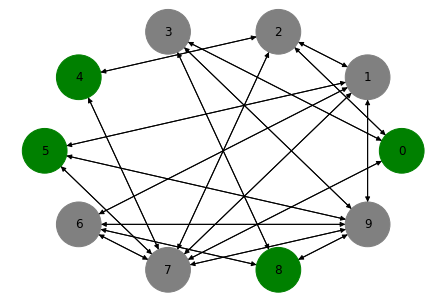

In [79]:
draw_entry(ex)

In [80]:
ex["weight"] = torch.ones([len(ex["y"])]).reshape(-1, 1)
ex.to(device)

Data(edge_index=[2, 40], weight=[10, 1], y=[10])

In [81]:
out = model(ex)
out

tensor([[0.2613],
        [0.1629],
        [0.1526],
        [0.2061],
        [0.3543],
        [0.3598],
        [0.2489],
        [0.0492],
        [0.2324],
        [0.0864]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [82]:
ans = out.detach().cpu().numpy().T.argsort()
ans

array([[7, 9, 2, 1, 3, 8, 6, 0, 4, 5]])

In [83]:
np.flip(ans)

array([[5, 4, 0, 6, 8, 3, 1, 2, 9, 7]])